# tampermonkey验证码识别

首先安装tesseract。

参考：
[Installation](https://github.com/tesseract-ocr/tessdoc/blob/master/Installation.md)

[tessdoc/Home](https://tesseract-ocr.github.io/tessdoc/Home.html)

编译安装方法

参考：[Compiling-GitInstallation](https://tesseract-ocr.github.io/tessdoc/Compiling-%E2%80%93-GitInstallation.html)

通过pip安装pytesseract

后台：

``` python
#!/usr/bin/env python

# ocr backend

import asyncio
import websockets
import base64
from io import BytesIO
from PIL import Image
import pytesseract


async def get_ocr(websocket, _):
    while True:
        # base64 encoded img file
        data = await websocket.recv()
        seq = 'base64,'
        pos = data.find(seq) + len(seq)
        x = base64.b64decode(data[pos:])
        # img file
        img = Image.open(BytesIO(x))
        # result
        a = pytesseract.image_to_string(img)
        out = a.strip().replace(" ", "")
        print(out)
        await websocket.send(out)


start_server = websockets.serve(get_ocr, "127.0.0.1", 5678)

asyncio.get_event_loop().run_until_complete(start_server)
asyncio.get_event_loop().run_forever()
```

参考:

1.  [base64 image
    conversion](https://jdhao.github.io/2020/03/17/base64_opencv_pil_image_conversion/)
2.  [github pytesseract](https://github.com/madmaze/pytesseract)
3.  [python
    websockets](https://websockets.readthedocs.io/en/stable/intro.html)

tampermonkey userjs:

``` javascript
(function () {
    'use strict';
    // get document element from xpath
    // code from stackoverflow
    function get_elem(a) {
        return document.evaluate(a, document, null,
            XPathResult.FIRST_ORDERED_NODE_TYPE, null).singleNodeValue;
    }

    // encode img to base64
    // see: ref 3
    function imgToBase64(img, dom) {
        const canvas = document.createElement('canvas');
        const ctx = canvas.getContext('2d');
        canvas.width = img.width;
        canvas.height = img.height;
        ctx.drawImage(img, 0, 0);
        // used for test canvas content
        // dom.appendChild(canvas);
        let data = "";
        data = canvas.toDataURL();
        return data;
    }

    var checkcode_dom = get_elem('//*[@id="checkcode_img"]');
    let checkcode_input = get_elem('//*[@id="checkcode"]');
    // get various elements
    let close_popup = get_elem('/html/body/div[5]/div[1]');
    // closing the annoying banner
    if (close_popup != null) {
        close_popup.click();
    }
    var dom = get_elem('//*[@id="yzm"]');
    dom.style = "";
    let username = get_elem('//*[@id="username"]');
    let password = get_elem('//*[@id="password"]');
    let login_btn = get_elem('//*[@id="login"]');

    if (username != null && password != null && login_btn != null) {
        //             // fill login form
        username.value = "test";
        password.value = "test";
    }

    // about websocket, see ref 2
    var ws = new WebSocket("ws://127.0.0.1:5678/");

    ws.onmessage = function (event) {
        let data = event.data;
        console.log(data);
        checkcode_input.value = data;
        // login_btn.click();
    }

    var a = 1;
    
    // specific dom loaded
    // ref: [1]
    var observer = new MutationObserver(function (mutationRecords) {
        console.log("change detected");
        let encodeded = imgToBase64(checkcode_dom, dom);
        ws.send(encodeded);
        if (a == 1) {
            console.log('add image onload trigger');
            checkcode_dom.onload = function () {
                let encodeded = imgToBase64(checkcode_dom, dom);
                ws.send(encodeded);
            }
            a = 0;
        }
    });

    observer.observe(get_elem('//*[@id="divNotice"]'), { childList: true });
})();
```

参考：

1.  [observe dom change -
    stackoverflow](https://stackoverflow.com/a/34864115)
2.  [websocket -
    mozilla](https://developer.mozilla.org/en-US/docs/Web/API/WebSockets_API/Writing_WebSocket_client_applications)
3.  [base64 image in
    javascript](https://dev.to/migsarnavarro/how-to-base64-encode-an-image-in-javascript-4k8e)

效果（2倍速）：

![img](_static/captcha.gif)

可以看到，识别并不是十分准确。
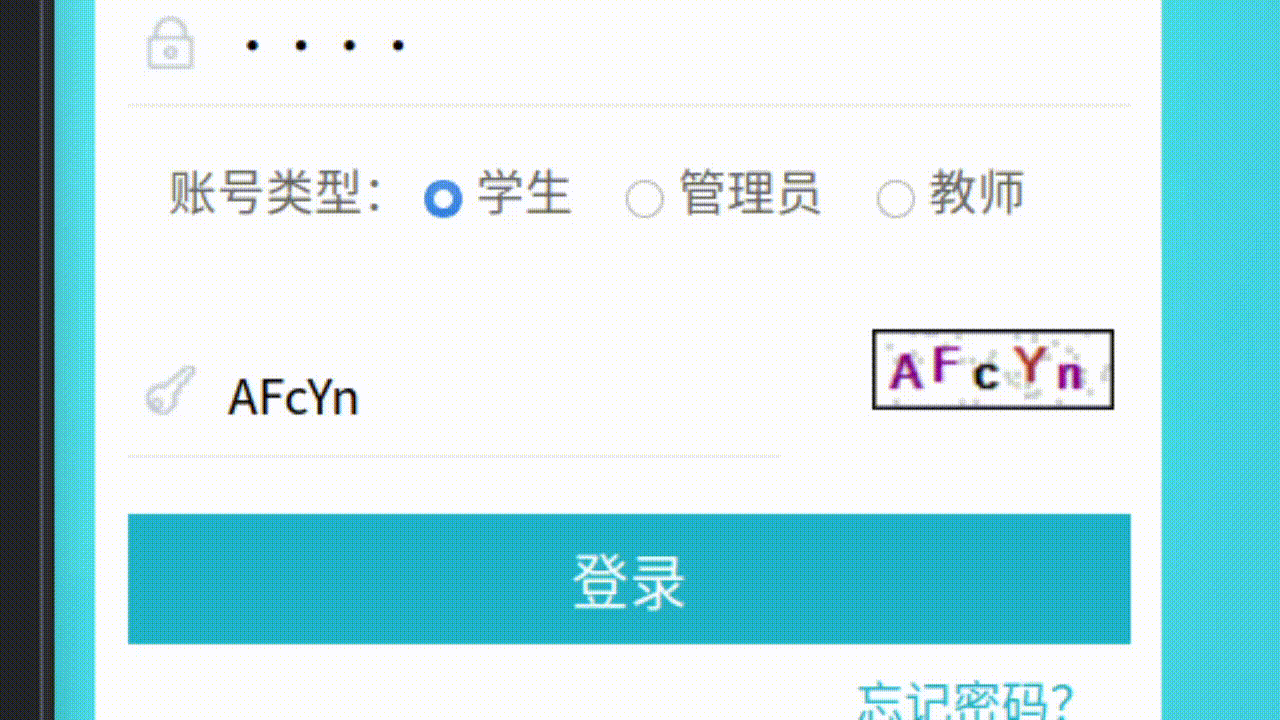